# Object Decetion with Faster RCNN from Torchvision


#### Mounting drive for dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installing library for Augmentation


In [2]:
# Install dependencies and 
!pip install albumentations==0.4.6
# !pip install pycocotools --quiet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 38.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=1207601a97461e296e2444e4a2753f06c19f987507f9d9a9a97e0bddcd0a6fd9
  Stored in directory: /root/.cache/pip/wheels/d2/e3/0b/99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


#### Importing Dependencies

In [4]:
import torch
import cv2
import os
from tqdm import tqdm
import numpy as np
import torchvision
import matplotlib.patches as patches
from dataclasses import dataclass
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# import utils
# import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from engine import train_one_epoch, evaluate

### Dataset preparation and Augmentation

In [5]:
files_dir = 'drive/MyDrive/Fruits_Data_Set/train_zip/train/'
test_dir = 'drive/MyDrive/Fruits_Data_Set/test_zip/test/'
import xml.etree.ElementTree as ET


class FruitsDataset(torch.utils.data.Dataset):

  def __init__(self, files_dir, width, height, transforms=None):
    self.transforms = transforms
    self.files_dir = files_dir
    self.height = height
    self.width = width
 
    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
    
    # classes: 0 index is reserved for background
    self.classes = [_, 'apple', 'orange', 'banana']
  
  def __extract_boxes_from_xml(self, xml_file):
    tree = ET.parse(xml_file)
    boxes = []
    classes = []
    for elem in tree.iter():
        if 'object' in elem.tag or 'part' in elem.tag:
            box = np.zeros((4))
            for attr in list(elem):
                if 'name' in attr.tag:
                    classes.append(self.classes.index(attr.text)) # 0:label for no bounding box
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            box[0] = int(round(float(dim.text)))
                        if 'ymin' in dim.tag:
                            box[1] = int(round(float(dim.text)))
                        if 'xmax' in dim.tag:
                            box[2] = int(round(float(dim.text)))
                        if 'ymax' in dim.tag:
                            box[3] = int(round(float(dim.text)))
            boxes.append(box)
    return boxes, classes

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

      
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
 
    img_res /= 255.0
    
    # annotation file
    annot_filename = img_name[:-4] + '.xml'
    annot_file_path = os.path.join(self.files_dir, annot_filename)
    
    original_boxes, labels = self.__extract_boxes_from_xml(annot_file_path)
    boxes = []
    
    # cv2 image gives size as height x width
    wt = img.shape[1]
    ht = img.shape[0]
    
    for box in original_boxes:
      xmin_corr = int(box[0]*(self.width/wt))
      xmax_corr = int(box[2]*(self.width/wt))
      ymin_corr = int(box[1]*(self.height/ht))
      ymax_corr = int(box[3]*(self.height/ht))
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
      
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
        
    return img_res, target

  def __len__(self):
    return len(self.imgs)


#### Augmentations

In [6]:
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        A.RandomRotate90(0.5),
        A.Rotate(limit=270, p=0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

#### Function to plot Augmented Data Examples

In [7]:
def aug_data_plot(org_img, org_target, aug1_img, aug1_target, aug2_img, aug2_target, aug3_img, aug3_target):
  fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)
  fig.set_size_inches(50,100)
  ax1.imshow(org_img)
  ax1.set_title("Original Image")
  label = org_target["labels"]
  for i, box in enumerate(org_target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 5,
      edgecolor = 'r' if label[i]==1 else 'b' if label[i] == 2  else 'g',
      facecolor = 'none',
      url = "Apple",
    )
    ax1.add_patch(rect)

  ax2.imshow(np.moveaxis(np.array(aug1_img),0,-1))
  ax2.set_title("Augmentation Example 1")
  label = aug1_target["labels"]
  for i, box in enumerate(aug1_target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 5,
      edgecolor = 'r' if label[i]==1 else 'b' if label[i] == 2  else 'g',
      facecolor = 'none',
      url = "Apple",
    )
    ax2.add_patch(rect)

  ax3.imshow(np.moveaxis(np.array(aug2_img),0,-1))
  ax3.set_title("Augmentation Example 2")
  label = aug2_target["labels"]
  for i, box in enumerate(aug2_target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 5,
      edgecolor = 'r' if label[i]==1 else 'b' if label[i] == 2  else 'g',
      facecolor = 'none',
      url = "Apple",
    )
    ax3.add_patch(rect)

  ax4.imshow(np.moveaxis(np.array(aug3_img),0,-1))
  ax4.set_title("Augmentation Example 3")
  label = aug3_target["labels"]
  for i, box in enumerate(aug3_target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 5,
      edgecolor = 'r' if label[i]==1 else 'b' if label[i] == 2  else 'g' ,
      facecolor = 'none',
      url = "Apple",
    )
    ax4.add_patch(rect)
  plt.show()

### Plotting Examples

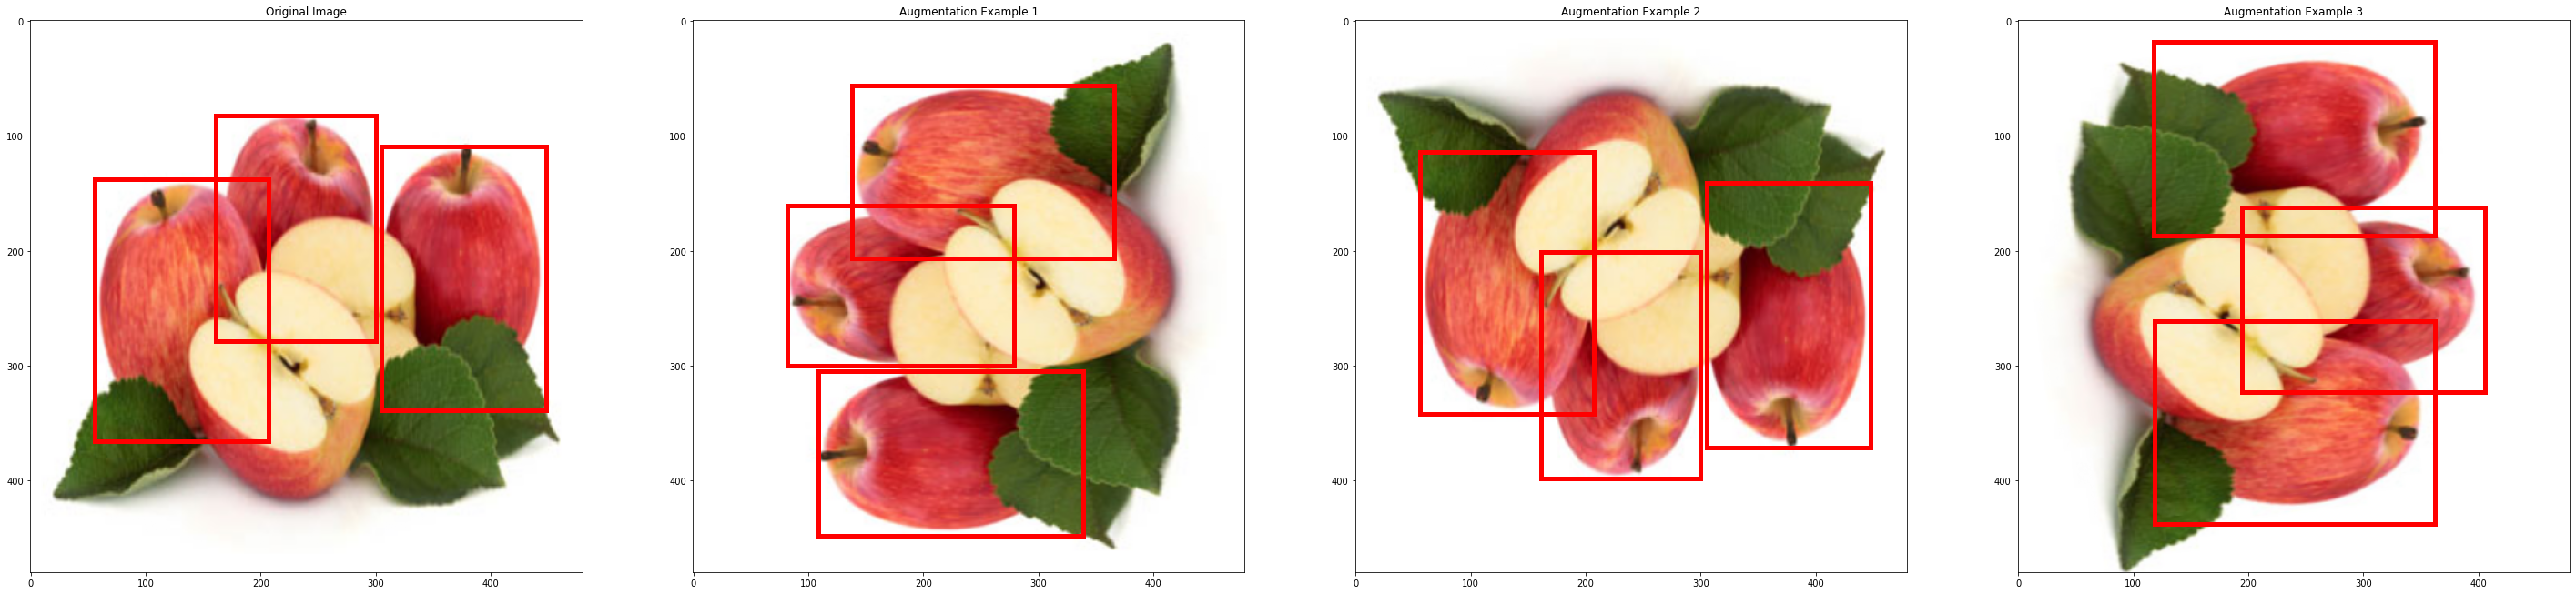

In [59]:
aug_dataset = FruitsDataset(files_dir, 480, 480, transforms=get_transform(True))
org_dataset = FruitsDataset(files_dir, 480, 480)
org_img, org_target = org_dataset[49]
aug1_img, aug1_target = aug_dataset[49]
aug2_img, aug2_target = aug_dataset[49]
aug3_img, aug3_target = aug_dataset[49]
aug_data_plot(org_img, org_target, aug1_img, aug1_target, aug2_img, aug2_target, aug3_img, aug3_target)


#### Function to plot bounding boxes on images

In [57]:
def plot_img_bbox(img, target):
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  label = target["labels"]
  for i, box in enumerate(target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 5,
      edgecolor = 'r',
      facecolor = 'none',
      url = "Apple",
    )
    a.add_patch(rect)

#### Defining Hyperparameters

In [10]:
@dataclass
class Hyperparameters:
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  num_classes = 4 
  num_workers = 2
  batch_size = 5
  learning_rate = 0.001
  momentum = 0.9
  train_val_split = 0.2
hyper_params = Hyperparameters()

#### Preparing DataLoaders

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))
# use our dataset and defined transformations
dataset = FruitsDataset(files_dir, 480, 480, transforms=get_transform(train=True))
# use our dataset and defined transformations
dataset_val = FruitsDataset(files_dir, 480, 480, transforms=get_transform(train=False))
dataset_test = FruitsDataset(test_dir, 480, 480, transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = hyper_params.train_val_split
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-tsize:])

# define training and validation data loaders
train_data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=hyper_params.batch_size,
  shuffle=True,
  num_workers=hyper_params.num_workers,
  collate_fn=collate_fn,
)

val_data_loader = torch.utils.data.DataLoader(
  dataset_val,
  batch_size=hyper_params.batch_size,
  shuffle=True,
  num_workers=hyper_params.num_workers,
  collate_fn=collate_fn,
)

test_data_loader = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=hyper_params.batch_size,
  shuffle=False,
  num_workers=hyper_params.num_workers,
  collate_fn=collate_fn,
)

#### Function to Load Model

In [19]:
def faster_rcnn_50(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

#### Training Setup

In [20]:
model = faster_rcnn_50(hyper_params.num_classes)
model.to(hyper_params.device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=hyper_params.learning_rate, momentum=hyper_params.momentum, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

#### Function to train one epoch

In [24]:
def one_epoch_train(model, optimizer, data_loader, device, epoch):
  loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
  running_loss = 0
  for i, (images, targets) in loop:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss = model(images, targets)
    print(loss)
    total_loss = sum(loss for loss in loss.values())
    running_loss += total_loss
    # with torch.no_grad():
    #   preds = model(images)
    # metric.update(preds, targets)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # lr_scheduler.step()
    loop.set_description(f"[{epoch}/{20}]")
    loop.set_postfix(loss=total_loss.item())
  print(f"Loss at the end of Epoch: {running_loss/39}")
  return running_loss/39




## Training 20 Epochs

In [25]:
num_epochs = 20
epoch_loss_total = []
for epoch in range(num_epochs):
    # training for one epoch
    epoch_loss = one_epoch_train(model, optimizer, train_data_loader, hyper_params.device, epoch)
    epoch_loss_total.append(epoch_loss)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

[0/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1733, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2999, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:   3%|▎         | 1/39 [00:01<00:51,  1.37s/it, loss=0.482]

{'loss_classifier': tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2113, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:   5%|▌         | 2/39 [00:02<00:42,  1.15s/it, loss=0.322]

{'loss_classifier': tensor(0.1286, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2592, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0080, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:   8%|▊         | 3/39 [00:03<00:38,  1.06s/it, loss=0.405]

{'loss_classifier': tensor(0.1421, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2592, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  10%|█         | 4/39 [00:04<00:35,  1.02s/it, loss=0.411]

{'loss_classifier': tensor(0.0657, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1048, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0016, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.01s/it, loss=0.183]

{'loss_classifier': tensor(0.2304, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4063, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0098, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  15%|█▌        | 6/39 [00:06<00:32,  1.00it/s, loss=0.656]

{'loss_classifier': tensor(0.0981, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1748, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  18%|█▊        | 7/39 [00:07<00:31,  1.01it/s, loss=0.281]

{'loss_classifier': tensor(0.1621, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  21%|██        | 8/39 [00:08<00:30,  1.01it/s, loss=0.461]

{'loss_classifier': tensor(0.2423, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4129, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0122, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  23%|██▎       | 9/39 [00:09<00:29,  1.01it/s, loss=0.678]

{'loss_classifier': tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2078, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  26%|██▌       | 10/39 [00:10<00:28,  1.01it/s, loss=0.328]

{'loss_classifier': tensor(0.1074, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2101, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0082, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  28%|██▊       | 11/39 [00:11<00:27,  1.01it/s, loss=0.329]

{'loss_classifier': tensor(0.0870, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2037, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0072, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  31%|███       | 12/39 [00:12<00:26,  1.01it/s, loss=0.302]

{'loss_classifier': tensor(0.1563, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0073, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  33%|███▎      | 13/39 [00:13<00:25,  1.00it/s, loss=0.474]

{'loss_classifier': tensor(0.1505, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2651, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0179, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  36%|███▌      | 14/39 [00:14<00:24,  1.00it/s, loss=0.438]

{'loss_classifier': tensor(0.1097, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2023, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  38%|███▊      | 15/39 [00:15<00:23,  1.00it/s, loss=0.317]

{'loss_classifier': tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1333, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  41%|████      | 16/39 [00:16<00:22,  1.00it/s, loss=0.208]

{'loss_classifier': tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1875, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  44%|████▎     | 17/39 [00:17<00:21,  1.00it/s, loss=0.3]

{'loss_classifier': tensor(0.1365, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2722, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  46%|████▌     | 18/39 [00:18<00:20,  1.01it/s, loss=0.417]

{'loss_classifier': tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1615, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  49%|████▊     | 19/39 [00:19<00:19,  1.00it/s, loss=0.24]

{'loss_classifier': tensor(0.1508, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3394, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  51%|█████▏    | 20/39 [00:20<00:18,  1.00it/s, loss=0.498]

{'loss_classifier': tensor(0.1015, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  54%|█████▍    | 21/39 [00:21<00:17,  1.00it/s, loss=0.316]

{'loss_classifier': tensor(0.1452, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2954, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0069, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  56%|█████▋    | 22/39 [00:22<00:16,  1.00it/s, loss=0.456]

{'loss_classifier': tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2253, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  59%|█████▉    | 23/39 [00:23<00:15,  1.00it/s, loss=0.324]

{'loss_classifier': tensor(0.2738, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4430, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0151, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0178, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.00s/it, loss=0.75]

{'loss_classifier': tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1152, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.194]

{'loss_classifier': tensor(0.1070, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2553, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0060, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.01s/it, loss=0.382]

{'loss_classifier': tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1615, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.266]

{'loss_classifier': tensor(0.1066, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2034, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.01s/it, loss=0.318]

{'loss_classifier': tensor(0.1330, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3030, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.01s/it, loss=0.447]

{'loss_classifier': tensor(0.1055, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1641, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0126, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0192, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.01s/it, loss=0.301]

{'loss_classifier': tensor(0.1029, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1581, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  79%|███████▉  | 31/39 [00:31<00:08,  1.01s/it, loss=0.265]

{'loss_classifier': tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1543, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  82%|████████▏ | 32/39 [00:32<00:07,  1.03s/it, loss=0.254]

{'loss_classifier': tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1974, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(9.5932e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  85%|████████▍ | 33/39 [00:33<00:06,  1.03s/it, loss=0.292]

{'loss_classifier': tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1756, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  87%|████████▋ | 34/39 [00:34<00:05,  1.02s/it, loss=0.286]

{'loss_classifier': tensor(0.1072, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2281, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  90%|████████▉ | 35/39 [00:35<00:04,  1.02s/it, loss=0.341]

{'loss_classifier': tensor(0.0697, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1635, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  92%|█████████▏| 36/39 [00:36<00:03,  1.02s/it, loss=0.245]

{'loss_classifier': tensor(0.0743, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1574, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0099, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  95%|█████████▍| 37/39 [00:37<00:02,  1.02s/it, loss=0.251]

{'loss_classifier': tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1805, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.02s/it, loss=0.267]

{'loss_classifier': tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0485, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)}


[0/20]: 100%|██████████| 39/39 [00:38<00:00,  1.00it/s, loss=0.0965]

Loss at the end of Epoch: 0.3533031642436981



[1/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1147, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:   3%|▎         | 1/39 [00:01<00:48,  1.28s/it, loss=0.166]

{'loss_classifier': tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1040, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:   5%|▌         | 2/39 [00:02<00:41,  1.13s/it, loss=0.168]

{'loss_classifier': tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1478, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:   8%|▊         | 3/39 [00:03<00:39,  1.09s/it, loss=0.225]

{'loss_classifier': tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1736, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  10%|█         | 4/39 [00:04<00:37,  1.07s/it, loss=0.266]

{'loss_classifier': tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2905, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0026, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.05s/it, loss=0.43]

{'loss_classifier': tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2201, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0031, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.04s/it, loss=0.331]

{'loss_classifier': tensor(0.0966, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2119, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  18%|█▊        | 7/39 [00:07<00:33,  1.04s/it, loss=0.326]

{'loss_classifier': tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0702, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  21%|██        | 8/39 [00:08<00:32,  1.04s/it, loss=0.135]

{'loss_classifier': tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2244, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  23%|██▎       | 9/39 [00:10<00:31,  1.04s/it, loss=0.333]

{'loss_classifier': tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2151, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  26%|██▌       | 10/39 [00:11<00:30,  1.04s/it, loss=0.312]

{'loss_classifier': tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0961, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  28%|██▊       | 11/39 [00:12<00:29,  1.06s/it, loss=0.164]

{'loss_classifier': tensor(0.1236, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2856, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  31%|███       | 12/39 [00:13<00:29,  1.08s/it, loss=0.418]

{'loss_classifier': tensor(0.0969, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2638, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  33%|███▎      | 13/39 [00:14<00:27,  1.07s/it, loss=0.369]

{'loss_classifier': tensor(0.0995, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2654, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0122, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0178, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  36%|███▌      | 14/39 [00:15<00:26,  1.05s/it, loss=0.395]

{'loss_classifier': tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2287, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0084, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  38%|███▊      | 15/39 [00:16<00:25,  1.05s/it, loss=0.337]

{'loss_classifier': tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2766, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  41%|████      | 16/39 [00:17<00:23,  1.04s/it, loss=0.408]

{'loss_classifier': tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2300, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.03s/it, loss=0.334]

{'loss_classifier': tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1696, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0069, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.03s/it, loss=0.276]

{'loss_classifier': tensor(0.1525, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2836, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0091, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.03s/it, loss=0.455]

{'loss_classifier': tensor(0.1257, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2389, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.02s/it, loss=0.373]

{'loss_classifier': tensor(0.1294, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2499, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0061, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.02s/it, loss=0.392]

{'loss_classifier': tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1405, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.02s/it, loss=0.206]

{'loss_classifier': tensor(0.1169, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2206, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.02s/it, loss=0.346]

{'loss_classifier': tensor(0.0614, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1193, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.02s/it, loss=0.19]

{'loss_classifier': tensor(0.1729, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3598, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0065, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.02s/it, loss=0.552]

{'loss_classifier': tensor(0.0645, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1970, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.27]

{'loss_classifier': tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1449, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0062, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.02s/it, loss=0.25]

{'loss_classifier': tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2646, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0049, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.396]

{'loss_classifier': tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1913, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.269]

{'loss_classifier': tensor(0.1260, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2196, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.352]

{'loss_classifier': tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1869, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.269]

{'loss_classifier': tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1883, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.275]

{'loss_classifier': tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1699, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.241]

{'loss_classifier': tensor(0.0768, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2479, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.329]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1651, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0070, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.00s/it, loss=0.234]

{'loss_classifier': tensor(0.0716, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1740, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0041, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  92%|█████████▏| 36/39 [00:37<00:02,  1.00it/s, loss=0.254]

{'loss_classifier': tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2308, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  95%|█████████▍| 37/39 [00:38<00:01,  1.00it/s, loss=0.318]

{'loss_classifier': tensor(0.1297, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2406, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]:  97%|█████████▋| 38/39 [00:39<00:00,  1.00it/s, loss=0.384]

{'loss_classifier': tensor(0.1470, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4026, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0116, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)}


[1/20]: 100%|██████████| 39/39 [00:39<00:00,  1.02s/it, loss=0.585]

Loss at the end of Epoch: 0.3161384165287018



[2/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2173, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:   3%|▎         | 1/39 [00:01<00:50,  1.32s/it, loss=0.321]

{'loss_classifier': tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2540, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:   5%|▌         | 2/39 [00:02<00:42,  1.14s/it, loss=0.351]

{'loss_classifier': tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1799, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0089, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.292]

{'loss_classifier': tensor(0.1504, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2841, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0094, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  10%|█         | 4/39 [00:04<00:36,  1.05s/it, loss=0.452]

{'loss_classifier': tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2018, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.299]

{'loss_classifier': tensor(0.0709, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1203, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.01s/it, loss=0.198]

{'loss_classifier': tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2390, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.01s/it, loss=0.347]

{'loss_classifier': tensor(0.1003, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2050, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  21%|██        | 8/39 [00:08<00:31,  1.01s/it, loss=0.313]

{'loss_classifier': tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1772, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0194, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.00s/it, loss=0.289]

{'loss_classifier': tensor(0.0530, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1365, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  26%|██▌       | 10/39 [00:10<00:28,  1.00it/s, loss=0.198]

{'loss_classifier': tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2842, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0210, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.00s/it, loss=0.425]

{'loss_classifier': tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2598, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0128, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  31%|███       | 12/39 [00:12<00:26,  1.00it/s, loss=0.353]

{'loss_classifier': tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1730, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0026, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  33%|███▎      | 13/39 [00:13<00:25,  1.01it/s, loss=0.278]

{'loss_classifier': tensor(0.0491, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0937, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  36%|███▌      | 14/39 [00:14<00:24,  1.01it/s, loss=0.147]

{'loss_classifier': tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1430, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  38%|███▊      | 15/39 [00:15<00:23,  1.00it/s, loss=0.204]

{'loss_classifier': tensor(0.0721, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1351, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0034, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  41%|████      | 16/39 [00:16<00:22,  1.01it/s, loss=0.214]

{'loss_classifier': tensor(0.0574, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1682, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0083, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  44%|████▎     | 17/39 [00:17<00:21,  1.01it/s, loss=0.242]

{'loss_classifier': tensor(0.1130, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3047, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  46%|████▌     | 18/39 [00:18<00:20,  1.01it/s, loss=0.426]

{'loss_classifier': tensor(0.1424, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2631, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0169, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  49%|████▊     | 19/39 [00:19<00:19,  1.00it/s, loss=0.425]

{'loss_classifier': tensor(0.0721, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1626, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0124, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  51%|█████▏    | 20/39 [00:20<00:18,  1.00it/s, loss=0.252]

{'loss_classifier': tensor(0.0586, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1325, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0200, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  54%|█████▍    | 21/39 [00:21<00:17,  1.00it/s, loss=0.215]

{'loss_classifier': tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1108, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.00s/it, loss=0.172]

{'loss_classifier': tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1798, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.271]

{'loss_classifier': tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1966, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.302]

{'loss_classifier': tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1606, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0066, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.257]

{'loss_classifier': tensor(0.0719, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1600, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.01s/it, loss=0.242]

{'loss_classifier': tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1543, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.243]

{'loss_classifier': tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1784, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0220, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.01s/it, loss=0.279]

{'loss_classifier': tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2516, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.01s/it, loss=0.344]

{'loss_classifier': tensor(0.0285, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0761, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.01s/it, loss=0.111]

{'loss_classifier': tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1506, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  79%|███████▉  | 31/39 [00:31<00:08,  1.01s/it, loss=0.236]

{'loss_classifier': tensor(0.0501, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0760, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0065, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  82%|████████▏ | 32/39 [00:32<00:07,  1.00s/it, loss=0.139]

{'loss_classifier': tensor(0.0449, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1360, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  85%|████████▍ | 33/39 [00:33<00:06,  1.01s/it, loss=0.19]

{'loss_classifier': tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1549, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  87%|████████▋ | 34/39 [00:34<00:05,  1.01s/it, loss=0.232]

{'loss_classifier': tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1432, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0075, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  90%|████████▉ | 35/39 [00:35<00:04,  1.01s/it, loss=0.194]

{'loss_classifier': tensor(0.1260, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2892, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  92%|█████████▏| 36/39 [00:36<00:03,  1.01s/it, loss=0.434]

{'loss_classifier': tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0525, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  95%|█████████▍| 37/39 [00:37<00:02,  1.00s/it, loss=0.109]

{'loss_classifier': tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1037, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.00s/it, loss=0.161]

{'loss_classifier': tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0500, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}


[2/20]: 100%|██████████| 39/39 [00:38<00:00,  1.00it/s, loss=0.0914]

Loss at the end of Epoch: 0.26280108094215393



[3/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0983, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2959, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0055, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0185, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:   3%|▎         | 1/39 [00:01<00:50,  1.33s/it, loss=0.418]

{'loss_classifier': tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0900, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:   5%|▌         | 2/39 [00:02<00:41,  1.13s/it, loss=0.148]

{'loss_classifier': tensor(0.0961, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2197, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0122, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:   8%|▊         | 3/39 [00:03<00:38,  1.08s/it, loss=0.336]

{'loss_classifier': tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2361, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  10%|█         | 4/39 [00:04<00:36,  1.05s/it, loss=0.33]

{'loss_classifier': tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1902, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.04s/it, loss=0.281]

{'loss_classifier': tensor(0.0970, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2466, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.03s/it, loss=0.351]

{'loss_classifier': tensor(0.1112, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2400, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0088, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.03s/it, loss=0.369]

{'loss_classifier': tensor(0.0582, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1199, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.186]

{'loss_classifier': tensor(0.1159, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2401, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0125, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.384]

{'loss_classifier': tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0914, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.02s/it, loss=0.149]

{'loss_classifier': tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2529, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.02s/it, loss=0.363]

{'loss_classifier': tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1825, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  31%|███       | 12/39 [00:12<00:27,  1.02s/it, loss=0.268]

{'loss_classifier': tensor(0.0436, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1023, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.02s/it, loss=0.151]

{'loss_classifier': tensor(0.0630, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2370, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.02s/it, loss=0.313]

{'loss_classifier': tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1976, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0067, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.02s/it, loss=0.299]

{'loss_classifier': tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1405, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  41%|████      | 16/39 [00:17<00:23,  1.02s/it, loss=0.194]

{'loss_classifier': tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0792, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.02s/it, loss=0.13]

{'loss_classifier': tensor(0.0542, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1610, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.02s/it, loss=0.222]

{'loss_classifier': tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1747, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.02s/it, loss=0.254]

{'loss_classifier': tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1462, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0145, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.224]

{'loss_classifier': tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1699, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0135, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.258]

{'loss_classifier': tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0800, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.132]

{'loss_classifier': tensor(0.0568, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2100, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0026, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.02s/it, loss=0.274]

{'loss_classifier': tensor(0.0927, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.277]

{'loss_classifier': tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1553, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.02s/it, loss=0.218]

{'loss_classifier': tensor(0.0601, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1017, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.168]

{'loss_classifier': tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1716, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.02s/it, loss=0.265]

{'loss_classifier': tensor(0.0505, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0869, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.146]

{'loss_classifier': tensor(0.0930, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1740, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.277]

{'loss_classifier': tensor(0.1166, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3194, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0070, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0135, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.456]

{'loss_classifier': tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1102, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.161]

{'loss_classifier': tensor(0.0383, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1131, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.02s/it, loss=0.158]

{'loss_classifier': tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1275, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.02s/it, loss=0.207]

{'loss_classifier': tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1679, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.02s/it, loss=0.239]

{'loss_classifier': tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0635, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.105]

{'loss_classifier': tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1378, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0062, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.231]

{'loss_classifier': tensor(0.1111, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2298, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.35]

{'loss_classifier': tensor(0.0525, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1279, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0055, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]:  97%|█████████▋| 38/39 [00:39<00:01,  1.01s/it, loss=0.193]

{'loss_classifier': tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0437, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)}


[3/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.0763]

Loss at the end of Epoch: 0.2452174425125122



[4/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0526, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1161, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:   3%|▎         | 1/39 [00:01<00:50,  1.32s/it, loss=0.175]

{'loss_classifier': tensor(0.0610, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1476, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:   5%|▌         | 2/39 [00:02<00:41,  1.13s/it, loss=0.219]

{'loss_classifier': tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2523, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0087, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0139, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.371]

{'loss_classifier': tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2721, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0082, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.408]

{'loss_classifier': tensor(0.0662, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1164, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0055, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.198]

{'loss_classifier': tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0979, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.146]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1512, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.01s/it, loss=0.212]

{'loss_classifier': tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1358, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  21%|██        | 8/39 [00:08<00:31,  1.01s/it, loss=0.199]

{'loss_classifier': tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1448, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.01s/it, loss=0.215]

{'loss_classifier': tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1240, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.00s/it, loss=0.174]

{'loss_classifier': tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2561, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0039, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.00s/it, loss=0.384]

{'loss_classifier': tensor(0.0655, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1858, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  31%|███       | 12/39 [00:12<00:27,  1.00s/it, loss=0.257]

{'loss_classifier': tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1959, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0073, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.00s/it, loss=0.278]

{'loss_classifier': tensor(0.1026, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2608, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.376]

{'loss_classifier': tensor(0.0408, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1010, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.145]

{'loss_classifier': tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2107, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0080, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  41%|████      | 16/39 [00:16<00:23,  1.00s/it, loss=0.316]

{'loss_classifier': tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1433, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.00s/it, loss=0.203]

{'loss_classifier': tensor(0.0833, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1796, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  46%|████▌     | 18/39 [00:18<00:20,  1.00it/s, loss=0.27]

{'loss_classifier': tensor(0.0285, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0779, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.00s/it, loss=0.11]

{'loss_classifier': tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0743, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.00s/it, loss=0.115]

{'loss_classifier': tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1264, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.00s/it, loss=0.189]

{'loss_classifier': tensor(0.0698, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1629, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.00s/it, loss=0.242]

{'loss_classifier': tensor(0.0652, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1650, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.24]

{'loss_classifier': tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1586, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0083, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.225]

{'loss_classifier': tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1341, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.224]

{'loss_classifier': tensor(0.0541, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1132, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.01s/it, loss=0.173]

{'loss_classifier': tensor(0.0553, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1129, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.177]

{'loss_classifier': tensor(0.0551, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1026, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0127, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.01s/it, loss=0.178]

{'loss_classifier': tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0994, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0056, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.01s/it, loss=0.163]

{'loss_classifier': tensor(0.1279, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2896, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0171, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.01s/it, loss=0.438]

{'loss_classifier': tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1480, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0077, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  79%|███████▉  | 31/39 [00:31<00:08,  1.01s/it, loss=0.226]

{'loss_classifier': tensor(0.0588, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1634, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  82%|████████▏ | 32/39 [00:32<00:07,  1.01s/it, loss=0.232]

{'loss_classifier': tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1580, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  85%|████████▍ | 33/39 [00:33<00:06,  1.01s/it, loss=0.25]

{'loss_classifier': tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0725, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  87%|████████▋ | 34/39 [00:34<00:05,  1.01s/it, loss=0.129]

{'loss_classifier': tensor(0.1258, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2714, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0069, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  90%|████████▉ | 35/39 [00:35<00:04,  1.01s/it, loss=0.412]

{'loss_classifier': tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2019, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  92%|█████████▏| 36/39 [00:36<00:03,  1.01s/it, loss=0.292]

{'loss_classifier': tensor(0.0515, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1628, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  95%|█████████▍| 37/39 [00:37<00:02,  1.01s/it, loss=0.225]

{'loss_classifier': tensor(0.0850, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1508, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.25]

{'loss_classifier': tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0920, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0073, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[4/20]: 100%|██████████| 39/39 [00:38<00:00,  1.00it/s, loss=0.176]

Loss at the end of Epoch: 0.23622210323810577



[5/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1509, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0140, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:   3%|▎         | 1/39 [00:01<00:52,  1.38s/it, loss=0.247]

{'loss_classifier': tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1869, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0135, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:   5%|▌         | 2/39 [00:02<00:42,  1.16s/it, loss=0.282]

{'loss_classifier': tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1992, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:   8%|▊         | 3/39 [00:03<00:39,  1.10s/it, loss=0.285]

{'loss_classifier': tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0859, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  10%|█         | 4/39 [00:04<00:37,  1.06s/it, loss=0.134]

{'loss_classifier': tensor(0.0657, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1540, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.04s/it, loss=0.234]

{'loss_classifier': tensor(0.0685, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1282, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.03s/it, loss=0.207]

{'loss_classifier': tensor(0.0651, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1625, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.236]

{'loss_classifier': tensor(0.0920, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2395, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0047, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0202, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.356]

{'loss_classifier': tensor(0.0969, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2393, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.346]

{'loss_classifier': tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0758, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0101, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.02s/it, loss=0.142]

{'loss_classifier': tensor(0.1459, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2918, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0080, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.02s/it, loss=0.454]

{'loss_classifier': tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  31%|███       | 12/39 [00:12<00:27,  1.02s/it, loss=0.135]

{'loss_classifier': tensor(0.0712, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1618, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  33%|███▎      | 13/39 [00:14<00:26,  1.02s/it, loss=0.24]

{'loss_classifier': tensor(0.1060, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2603, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  36%|███▌      | 14/39 [00:15<00:25,  1.02s/it, loss=0.377]

{'loss_classifier': tensor(0.0754, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1718, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(7.2547e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  38%|███▊      | 15/39 [00:16<00:24,  1.01s/it, loss=0.255]

{'loss_classifier': tensor(0.1154, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3358, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0073, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  41%|████      | 16/39 [00:17<00:23,  1.02s/it, loss=0.473]

{'loss_classifier': tensor(0.0737, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1373, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.02s/it, loss=0.215]

{'loss_classifier': tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2090, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.02s/it, loss=0.299]

{'loss_classifier': tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0861, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0016, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.01s/it, loss=0.136]

{'loss_classifier': tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0986, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.158]

{'loss_classifier': tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1193, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.172]

{'loss_classifier': tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0406, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.071]

{'loss_classifier': tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0956, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.172]

{'loss_classifier': tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1481, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.233]

{'loss_classifier': tensor(0.0681, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1572, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.232]

{'loss_classifier': tensor(0.0741, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2246, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0129, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.315]

{'loss_classifier': tensor(0.0482, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0904, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.143]

{'loss_classifier': tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1664, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.246]

{'loss_classifier': tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1330, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.21]

{'loss_classifier': tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1693, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.26]

{'loss_classifier': tensor(0.0658, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1279, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.203]

{'loss_classifier': tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1531, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0081, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.229]

{'loss_classifier': tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1996, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.287]

{'loss_classifier': tensor(0.0549, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1400, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.204]

{'loss_classifier': tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2208, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.324]

{'loss_classifier': tensor(0.0585, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1136, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.00s/it, loss=0.179]

{'loss_classifier': tensor(0.0374, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0693, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.00s/it, loss=0.113]

{'loss_classifier': tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1459, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.00s/it, loss=0.226]

{'loss_classifier': tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(3.0979e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)}


[5/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.124]

Loss at the end of Epoch: 0.23472903668880463



[6/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0781, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1625, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0149, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:   3%|▎         | 1/39 [00:01<00:50,  1.34s/it, loss=0.257]

{'loss_classifier': tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1030, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0302, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:   5%|▌         | 2/39 [00:02<00:41,  1.13s/it, loss=0.225]

{'loss_classifier': tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0713, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:   8%|▊         | 3/39 [00:03<00:38,  1.08s/it, loss=0.117]

{'loss_classifier': tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2195, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0189, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  10%|█         | 4/39 [00:04<00:36,  1.05s/it, loss=0.315]

{'loss_classifier': tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1243, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.223]

{'loss_classifier': tensor(0.0633, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1392, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.207]

{'loss_classifier': tensor(0.1606, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4017, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0174, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.584]

{'loss_classifier': tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0980, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(7.8628e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.158]

{'loss_classifier': tensor(0.0422, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0881, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.134]

{'loss_classifier': tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1068, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.157]

{'loss_classifier': tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2000, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0080, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.323]

{'loss_classifier': tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1776, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.256]

{'loss_classifier': tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1726, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.01s/it, loss=0.245]

{'loss_classifier': tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0806, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.125]

{'loss_classifier': tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2127, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.309]

{'loss_classifier': tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1039, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(7.7010e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.162]

{'loss_classifier': tensor(0.0960, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2597, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0042, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.372]

{'loss_classifier': tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1557, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.21]

{'loss_classifier': tensor(0.0460, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0664, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.116]

{'loss_classifier': tensor(0.1138, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2713, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0071, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.404]

{'loss_classifier': tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1170, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.175]

{'loss_classifier': tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1048, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.165]

{'loss_classifier': tensor(0.0411, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0555, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.105]

{'loss_classifier': tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2300, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.332]

{'loss_classifier': tensor(0.0665, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1431, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.22]

{'loss_classifier': tensor(0.0614, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1329, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.203]

{'loss_classifier': tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1691, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.24]

{'loss_classifier': tensor(0.0315, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0581, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.0983]

{'loss_classifier': tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1013, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.157]

{'loss_classifier': tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1667, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0076, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.254]

{'loss_classifier': tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1784, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.235]

{'loss_classifier': tensor(0.0825, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1230, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.00s/it, loss=0.211]

{'loss_classifier': tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1091, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.168]

{'loss_classifier': tensor(0.0522, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1099, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0016, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.00s/it, loss=0.171]

{'loss_classifier': tensor(0.0383, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0748, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.125]

{'loss_classifier': tensor(0.0827, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2257, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0052, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.325]

{'loss_classifier': tensor(0.1109, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2716, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0106, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.404]

{'loss_classifier': tensor(0.0779, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1803, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.269]

{'loss_classifier': tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0773, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(6.0813e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[6/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.119]

Loss at the end of Epoch: 0.22764289379119873



[7/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2563, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:   3%|▎         | 1/39 [00:01<00:47,  1.25s/it, loss=0.388]

{'loss_classifier': tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1533, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:   5%|▌         | 2/39 [00:02<00:41,  1.11s/it, loss=0.206]

{'loss_classifier': tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0848, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.132]

{'loss_classifier': tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1913, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.283]

{'loss_classifier': tensor(0.0944, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2477, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.03s/it, loss=0.356]

{'loss_classifier': tensor(0.1122, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1774, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0124, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.307]

{'loss_classifier': tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1632, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.255]

{'loss_classifier': tensor(0.0204, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0573, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.0821]

{'loss_classifier': tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1197, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0062, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.197]

{'loss_classifier': tensor(0.0944, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1722, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.275]

{'loss_classifier': tensor(0.0827, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1802, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.272]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1242, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.187]

{'loss_classifier': tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1536, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.01s/it, loss=0.222]

{'loss_classifier': tensor(0.0648, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2010, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.283]

{'loss_classifier': tensor(0.1120, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2822, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0054, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.41]

{'loss_classifier': tensor(0.0742, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1817, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0069, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.276]

{'loss_classifier': tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1515, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0119, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.217]

{'loss_classifier': tensor(0.0778, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2285, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.315]

{'loss_classifier': tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1251, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.184]

{'loss_classifier': tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0981, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.147]

{'loss_classifier': tensor(0.0783, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1836, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.272]

{'loss_classifier': tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2328, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.322]

{'loss_classifier': tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2369, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0121, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.357]

{'loss_classifier': tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0788, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.00s/it, loss=0.116]

{'loss_classifier': tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0806, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.00s/it, loss=0.129]

{'loss_classifier': tensor(0.0810, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2516, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.00s/it, loss=0.343]

{'loss_classifier': tensor(0.0530, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0913, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.149]

{'loss_classifier': tensor(0.0703, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1401, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0026, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.01s/it, loss=0.216]

{'loss_classifier': tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0706, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.01s/it, loss=0.121]

{'loss_classifier': tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1520, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.01s/it, loss=0.224]

{'loss_classifier': tensor(0.0754, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1628, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  79%|███████▉  | 31/39 [00:31<00:08,  1.01s/it, loss=0.245]

{'loss_classifier': tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2034, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  82%|████████▏ | 32/39 [00:32<00:07,  1.01s/it, loss=0.317]

{'loss_classifier': tensor(0.0488, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1258, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0191, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  85%|████████▍ | 33/39 [00:33<00:06,  1.01s/it, loss=0.196]

{'loss_classifier': tensor(0.0741, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1797, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0073, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  87%|████████▋ | 34/39 [00:34<00:05,  1.01s/it, loss=0.275]

{'loss_classifier': tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1003, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  90%|████████▉ | 35/39 [00:35<00:04,  1.00s/it, loss=0.15]

{'loss_classifier': tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0795, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  92%|█████████▏| 36/39 [00:36<00:03,  1.01s/it, loss=0.149]

{'loss_classifier': tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0528, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0069, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.104]

{'loss_classifier': tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1098, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.00s/it, loss=0.167]

{'loss_classifier': tensor(0.0334, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0759, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(6.1683e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)}


[7/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.112]

Loss at the end of Epoch: 0.22963427007198334



[8/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1270, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0041, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:   3%|▎         | 1/39 [00:01<00:47,  1.25s/it, loss=0.384]

{'loss_classifier': tensor(0.0633, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1026, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0072, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:   5%|▌         | 2/39 [00:02<00:41,  1.11s/it, loss=0.181]

{'loss_classifier': tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1079, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.163]

{'loss_classifier': tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1412, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.218]

{'loss_classifier': tensor(0.0631, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1303, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0061, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0171, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.03s/it, loss=0.217]

{'loss_classifier': tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1358, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.198]

{'loss_classifier': tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1198, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.173]

{'loss_classifier': tensor(0.0347, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0940, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  21%|██        | 8/39 [00:08<00:31,  1.01s/it, loss=0.134]

{'loss_classifier': tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0961, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.01s/it, loss=0.147]

{'loss_classifier': tensor(0.0585, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1752, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0067, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.249]

{'loss_classifier': tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.165]

{'loss_classifier': tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1866, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.27]

{'loss_classifier': tensor(0.0420, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1362, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.01s/it, loss=0.187]

{'loss_classifier': tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0631, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.00s/it, loss=0.104]

{'loss_classifier': tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0939, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.163]

{'loss_classifier': tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1554, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.232]

{'loss_classifier': tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0988, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.16]

{'loss_classifier': tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1143, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.176]

{'loss_classifier': tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2271, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.339]

{'loss_classifier': tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1736, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0103, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.281]

{'loss_classifier': tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2169, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0100, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.312]

{'loss_classifier': tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1597, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.237]

{'loss_classifier': tensor(0.0693, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1672, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.244]

{'loss_classifier': tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0711, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0063, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.114]

{'loss_classifier': tensor(0.0475, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1190, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.173]

{'loss_classifier': tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0923, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.01s/it, loss=0.132]

{'loss_classifier': tensor(0.1142, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3396, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0041, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.471]

{'loss_classifier': tensor(0.1121, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2588, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0039, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0185, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.01s/it, loss=0.393]

{'loss_classifier': tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.01s/it, loss=0.0563]

{'loss_classifier': tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1999, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0055, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.01s/it, loss=0.308]

{'loss_classifier': tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3034, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  79%|███████▉  | 31/39 [00:31<00:08,  1.01s/it, loss=0.427]

{'loss_classifier': tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1017, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  82%|████████▏ | 32/39 [00:32<00:07,  1.01s/it, loss=0.155]

{'loss_classifier': tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2246, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.343]

{'loss_classifier': tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2014, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0062, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.296]

{'loss_classifier': tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2653, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.37]

{'loss_classifier': tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1380, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.202]

{'loss_classifier': tensor(0.1454, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3277, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0111, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0206, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.505]

{'loss_classifier': tensor(0.0460, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1311, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.182]

{'loss_classifier': tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0860, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)}


[8/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.148]

Loss at the end of Epoch: 0.23618526756763458



[9/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2043, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:   3%|▎         | 1/39 [00:01<00:47,  1.26s/it, loss=0.311]

{'loss_classifier': tensor(0.0497, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1130, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(9.4295e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:   5%|▌         | 2/39 [00:02<00:41,  1.11s/it, loss=0.166]

{'loss_classifier': tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1241, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:   8%|▊         | 3/39 [00:03<00:38,  1.06s/it, loss=0.192]

{'loss_classifier': tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1313, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0054, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  10%|█         | 4/39 [00:04<00:36,  1.03s/it, loss=0.187]

{'loss_classifier': tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1903, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.254]

{'loss_classifier': tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1075, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(7.7306e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.172]

{'loss_classifier': tensor(0.0923, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1478, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.01s/it, loss=0.249]

{'loss_classifier': tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1703, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0237, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  21%|██        | 8/39 [00:08<00:31,  1.01s/it, loss=0.303]

{'loss_classifier': tensor(0.0719, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1473, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.4799e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.00s/it, loss=0.226]

{'loss_classifier': tensor(0.0591, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1502, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.221]

{'loss_classifier': tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2181, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0041, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0143, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.35]

{'loss_classifier': tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1189, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.178]

{'loss_classifier': tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1613, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.01s/it, loss=0.242]

{'loss_classifier': tensor(0.0530, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1060, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.168]

{'loss_classifier': tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2387, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.33]

{'loss_classifier': tensor(0.0729, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2036, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.284]

{'loss_classifier': tensor(0.0691, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1406, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.216]

{'loss_classifier': tensor(0.0751, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1614, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.25]

{'loss_classifier': tensor(0.0849, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1954, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0053, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.297]

{'loss_classifier': tensor(0.0600, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0049, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.247]

{'loss_classifier': tensor(0.0693, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1362, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.213]

{'loss_classifier': tensor(0.0607, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1247, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.197]

{'loss_classifier': tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1301, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.183]

{'loss_classifier': tensor(0.1318, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2284, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0092, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.382]

{'loss_classifier': tensor(0.1180, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2971, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0070, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.432]

{'loss_classifier': tensor(0.0573, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1362, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.01s/it, loss=0.2]

{'loss_classifier': tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1626, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0026, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.258]

{'loss_classifier': tensor(0.0403, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1097, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.02s/it, loss=0.156]

{'loss_classifier': tensor(0.0894, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1780, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.02s/it, loss=0.276]

{'loss_classifier': tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1152, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0072, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.02s/it, loss=0.178]

{'loss_classifier': tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1250, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.02s/it, loss=0.194]

{'loss_classifier': tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1344, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.02s/it, loss=0.186]

{'loss_classifier': tensor(0.1246, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2903, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.02s/it, loss=0.425]

{'loss_classifier': tensor(0.0526, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1509, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.209]

{'loss_classifier': tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0067, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.176]

{'loss_classifier': tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1559, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.221]

{'loss_classifier': tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1711, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.269]

{'loss_classifier': tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0502, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.0915]

{'loss_classifier': tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1022, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[9/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.14]

Loss at the end of Epoch: 0.23669081926345825



[10/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1871, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:   3%|▎         | 1/39 [00:01<00:49,  1.30s/it, loss=0.274]

{'loss_classifier': tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1386, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:   5%|▌         | 2/39 [00:02<00:41,  1.13s/it, loss=0.209]

{'loss_classifier': tensor(0.0647, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1537, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0048, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:   8%|▊         | 3/39 [00:03<00:39,  1.09s/it, loss=0.236]

{'loss_classifier': tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0828, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  10%|█         | 4/39 [00:04<00:37,  1.06s/it, loss=0.124]

{'loss_classifier': tensor(0.1027, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2176, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.04s/it, loss=0.332]

{'loss_classifier': tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1151, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.03s/it, loss=0.192]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1439, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.03s/it, loss=0.207]

{'loss_classifier': tensor(0.1103, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2254, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.346]

{'loss_classifier': tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1941, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0085, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.28]

{'loss_classifier': tensor(0.0401, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1187, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.03s/it, loss=0.168]

{'loss_classifier': tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0684, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  28%|██▊       | 11/39 [00:12<00:28,  1.03s/it, loss=0.114]

{'loss_classifier': tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1623, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  31%|███       | 12/39 [00:13<00:27,  1.03s/it, loss=0.222]

{'loss_classifier': tensor(0.0635, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1714, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  33%|███▎      | 13/39 [00:14<00:26,  1.02s/it, loss=0.24]

{'loss_classifier': tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1861, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  36%|███▌      | 14/39 [00:15<00:25,  1.02s/it, loss=0.28]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0637, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  38%|███▊      | 15/39 [00:16<00:24,  1.02s/it, loss=0.127]

{'loss_classifier': tensor(0.0515, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1074, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  41%|████      | 16/39 [00:17<00:23,  1.02s/it, loss=0.163]

{'loss_classifier': tensor(0.0601, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1523, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0081, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.02s/it, loss=0.227]

{'loss_classifier': tensor(0.1478, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3618, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0031, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.02s/it, loss=0.525]

{'loss_classifier': tensor(0.0745, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1340, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.02s/it, loss=0.217]

{'loss_classifier': tensor(0.0686, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1958, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.275]

{'loss_classifier': tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0857, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.138]

{'loss_classifier': tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1794, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.269]

{'loss_classifier': tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1189, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.184]

{'loss_classifier': tensor(0.0811, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1638, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.02s/it, loss=0.25]

{'loss_classifier': tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1543, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.229]

{'loss_classifier': tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1138, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0065, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.17]

{'loss_classifier': tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0857, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.138]

{'loss_classifier': tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1471, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.2]

{'loss_classifier': tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1730, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0081, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.267]

{'loss_classifier': tensor(0.0434, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1138, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.163]

{'loss_classifier': tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2377, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.323]

{'loss_classifier': tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2118, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.316]

{'loss_classifier': tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1341, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.192]

{'loss_classifier': tensor(0.0759, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1919, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0039, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.285]

{'loss_classifier': tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1279, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.203]

{'loss_classifier': tensor(0.0599, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1576, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.226]

{'loss_classifier': tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1292, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0079, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.214]

{'loss_classifier': tensor(0.0390, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0829, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]:  97%|█████████▋| 38/39 [00:39<00:01,  1.00s/it, loss=0.125]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0795, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)}


[10/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.14]

Loss at the end of Epoch: 0.2253192514181137



[11/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1135, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:   3%|▎         | 1/39 [00:01<00:47,  1.26s/it, loss=0.174]

{'loss_classifier': tensor(0.0704, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1541, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:   5%|▌         | 2/39 [00:02<00:41,  1.11s/it, loss=0.234]

{'loss_classifier': tensor(0.0565, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1545, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0068, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:   8%|▊         | 3/39 [00:03<00:38,  1.06s/it, loss=0.225]

{'loss_classifier': tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1656, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.257]

{'loss_classifier': tensor(0.0465, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1099, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.161]

{'loss_classifier': tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1100, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.155]

{'loss_classifier': tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2163, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0088, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.331]

{'loss_classifier': tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0973, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.167]

{'loss_classifier': tensor(0.0563, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0863, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.149]

{'loss_classifier': tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0953, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.157]

{'loss_classifier': tensor(0.0412, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1049, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.154]

{'loss_classifier': tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2246, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0153, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0128, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.359]

{'loss_classifier': tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0964, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.01s/it, loss=0.148]

{'loss_classifier': tensor(0.1070, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2436, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0100, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.367]

{'loss_classifier': tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0667, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.113]

{'loss_classifier': tensor(0.0649, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1424, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.214]

{'loss_classifier': tensor(0.0950, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2238, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.332]

{'loss_classifier': tensor(0.0516, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0815, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.143]

{'loss_classifier': tensor(0.1472, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2424, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0072, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.407]

{'loss_classifier': tensor(0.0585, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1421, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0041, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.211]

{'loss_classifier': tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1642, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0166, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.277]

{'loss_classifier': tensor(0.0916, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2165, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.325]

{'loss_classifier': tensor(0.0785, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1778, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.265]

{'loss_classifier': tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2134, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0101, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.312]

{'loss_classifier': tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1693, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.243]

{'loss_classifier': tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1887, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  67%|██████▋   | 26/39 [00:26<00:13,  1.01s/it, loss=0.251]

{'loss_classifier': tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1042, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0110, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  69%|██████▉   | 27/39 [00:27<00:12,  1.01s/it, loss=0.17]

{'loss_classifier': tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2143, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  72%|███████▏  | 28/39 [00:28<00:11,  1.01s/it, loss=0.328]

{'loss_classifier': tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1689, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  74%|███████▍  | 29/39 [00:29<00:10,  1.01s/it, loss=0.275]

{'loss_classifier': tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1221, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  77%|███████▋  | 30/39 [00:30<00:09,  1.01s/it, loss=0.187]

{'loss_classifier': tensor(0.1253, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3014, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0075, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.446]

{'loss_classifier': tensor(0.1157, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2581, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.386]

{'loss_classifier': tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0857, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.14]

{'loss_classifier': tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0703, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.132]

{'loss_classifier': tensor(0.0580, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1242, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.4254e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.185]

{'loss_classifier': tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0587, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.0845]

{'loss_classifier': tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0608, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.00s/it, loss=0.109]

{'loss_classifier': tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0962, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.00s/it, loss=0.154]

{'loss_classifier': tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1125, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0083, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[11/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.171]

Loss at the end of Epoch: 0.22819136083126068



[12/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1536, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:   3%|▎         | 1/39 [00:01<00:48,  1.26s/it, loss=0.23]

{'loss_classifier': tensor(0.1368, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2880, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:   5%|▌         | 2/39 [00:02<00:41,  1.11s/it, loss=0.454]

{'loss_classifier': tensor(0.0768, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1467, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.236]

{'loss_classifier': tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0647, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  10%|█         | 4/39 [00:04<00:36,  1.05s/it, loss=0.1]

{'loss_classifier': tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1070, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.164]

{'loss_classifier': tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1770, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0093, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.253]

{'loss_classifier': tensor(0.0745, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2098, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.299]

{'loss_classifier': tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2420, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0072, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.389]

{'loss_classifier': tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1477, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.01s/it, loss=0.227]

{'loss_classifier': tensor(0.1118, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3495, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0102, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.484]

{'loss_classifier': tensor(0.0255, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0675, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.0982]

{'loss_classifier': tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2007, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0151, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.32]

{'loss_classifier': tensor(0.0946, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2003, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.01s/it, loss=0.307]

{'loss_classifier': tensor(0.0999, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2556, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.37]

{'loss_classifier': tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0881, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.129]

{'loss_classifier': tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1656, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.229]

{'loss_classifier': tensor(0.0618, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1231, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.193]

{'loss_classifier': tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0723, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.119]

{'loss_classifier': tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1193, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.178]

{'loss_classifier': tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1940, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.289]

{'loss_classifier': tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1708, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0208, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.282]

{'loss_classifier': tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1986, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.288]

{'loss_classifier': tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1154, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.195]

{'loss_classifier': tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2087, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0105, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.333]

{'loss_classifier': tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1306, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.201]

{'loss_classifier': tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0972, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.153]

{'loss_classifier': tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1140, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.152]

{'loss_classifier': tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1755, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.24]

{'loss_classifier': tensor(0.0352, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0754, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.115]

{'loss_classifier': tensor(0.0568, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1051, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.174]

{'loss_classifier': tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0612, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.106]

{'loss_classifier': tensor(0.0667, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1180, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0033, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.00s/it, loss=0.194]

{'loss_classifier': tensor(0.1156, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2690, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0119, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.00s/it, loss=0.402]

{'loss_classifier': tensor(0.0658, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1562, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.232]

{'loss_classifier': tensor(0.0946, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2481, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0125, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.357]

{'loss_classifier': tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1374, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.00s/it, loss=0.206]

{'loss_classifier': tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1536, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.227]

{'loss_classifier': tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1118, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.176]

{'loss_classifier': tensor(0.0563, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0737, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)}


[12/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.133]

Loss at the end of Epoch: 0.23675937950611115



[13/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1289, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2584, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0173, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:   3%|▎         | 1/39 [00:01<00:49,  1.30s/it, loss=0.406]

{'loss_classifier': tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1781, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:   5%|▌         | 2/39 [00:02<00:41,  1.13s/it, loss=0.279]

{'loss_classifier': tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1527, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0031, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:   8%|▊         | 3/39 [00:03<00:38,  1.08s/it, loss=0.217]

{'loss_classifier': tensor(0.0539, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1221, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.179]

{'loss_classifier': tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2377, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0168, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  13%|█▎        | 5/39 [00:05<00:34,  1.03s/it, loss=0.359]

{'loss_classifier': tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1032, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0071, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.171]

{'loss_classifier': tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1640, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.24]

{'loss_classifier': tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1338, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  21%|██        | 8/39 [00:08<00:31,  1.01s/it, loss=0.23]

{'loss_classifier': tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2194, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0048, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0160, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.01s/it, loss=0.331]

{'loss_classifier': tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1147, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.168]

{'loss_classifier': tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1167, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.187]

{'loss_classifier': tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0940, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.164]

{'loss_classifier': tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1043, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0041, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.02s/it, loss=0.15]

{'loss_classifier': tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1785, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.02s/it, loss=0.266]

{'loss_classifier': tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0498, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.0839]

{'loss_classifier': tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0981, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.155]

{'loss_classifier': tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0917, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.148]

{'loss_classifier': tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1998, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0034, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.268]

{'loss_classifier': tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0620, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0092, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.123]

{'loss_classifier': tensor(0.0814, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1744, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.262]

{'loss_classifier': tensor(0.0625, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1449, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0047, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.224]

{'loss_classifier': tensor(0.0402, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0793, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.125]

{'loss_classifier': tensor(0.1976, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3742, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0088, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.594]

{'loss_classifier': tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1055, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  62%|██████▏   | 24/39 [00:24<00:15,  1.01s/it, loss=0.172]

{'loss_classifier': tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0666, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  64%|██████▍   | 25/39 [00:25<00:14,  1.01s/it, loss=0.114]

{'loss_classifier': tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1430, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.212]

{'loss_classifier': tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1250, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.189]

{'loss_classifier': tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2313, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0089, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.335]

{'loss_classifier': tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2202, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(9.4136e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.322]

{'loss_classifier': tensor(0.0428, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0978, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(9.7051e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.144]

{'loss_classifier': tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1949, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.296]

{'loss_classifier': tensor(0.1093, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2858, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.409]

{'loss_classifier': tensor(0.0790, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2048, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.294]

{'loss_classifier': tensor(0.0999, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2200, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.33]

{'loss_classifier': tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0686, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.105]

{'loss_classifier': tensor(0.0846, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3459, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0139, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.445]

{'loss_classifier': tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0783, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.133]

{'loss_classifier': tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2570, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0031, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.359]

{'loss_classifier': tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0752, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)}


[13/20]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.151]

Loss at the end of Epoch: 0.2394740730524063



[14/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0732, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1991, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:   3%|▎         | 1/39 [00:01<00:50,  1.34s/it, loss=0.281]

{'loss_classifier': tensor(0.0701, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2051, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:   5%|▌         | 2/39 [00:02<00:42,  1.14s/it, loss=0.286]

{'loss_classifier': tensor(0.0575, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1038, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:   8%|▊         | 3/39 [00:03<00:38,  1.08s/it, loss=0.181]

{'loss_classifier': tensor(0.0548, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1324, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  10%|█         | 4/39 [00:04<00:36,  1.05s/it, loss=0.191]

{'loss_classifier': tensor(0.0366, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0655, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(9.2643e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.04s/it, loss=0.105]

{'loss_classifier': tensor(0.0877, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2824, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0059, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.03s/it, loss=0.384]

{'loss_classifier': tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1418, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0055, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  18%|█▊        | 7/39 [00:07<00:33,  1.03s/it, loss=0.216]

{'loss_classifier': tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1194, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.192]

{'loss_classifier': tensor(0.0286, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0616, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.03s/it, loss=0.0993]

{'loss_classifier': tensor(0.0583, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1247, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0050, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.02s/it, loss=0.194]

{'loss_classifier': tensor(0.0540, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0958, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.02s/it, loss=0.158]

{'loss_classifier': tensor(0.0953, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1929, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.304]

{'loss_classifier': tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1547, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.02s/it, loss=0.251]

{'loss_classifier': tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1379, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.214]

{'loss_classifier': tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1109, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.168]

{'loss_classifier': tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1209, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  41%|████      | 16/39 [00:17<00:23,  1.01s/it, loss=0.212]

{'loss_classifier': tensor(0.0954, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2123, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0172, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.02s/it, loss=0.331]

{'loss_classifier': tensor(0.0657, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1816, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0063, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.01s/it, loss=0.258]

{'loss_classifier': tensor(0.0465, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0974, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.01s/it, loss=0.149]

{'loss_classifier': tensor(0.1090, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1950, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0049, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.314]

{'loss_classifier': tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1387, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.222]

{'loss_classifier': tensor(0.1178, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2116, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0082, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.343]

{'loss_classifier': tensor(0.0502, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1163, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.175]

{'loss_classifier': tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1729, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.271]

{'loss_classifier': tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1583, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.251]

{'loss_classifier': tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0697, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.114]

{'loss_classifier': tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1525, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.02s/it, loss=0.222]

{'loss_classifier': tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1758, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.258]

{'loss_classifier': tensor(0.0681, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1429, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.219]

{'loss_classifier': tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1906, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.267]

{'loss_classifier': tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0840, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0016, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.13]

{'loss_classifier': tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0576, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.105]

{'loss_classifier': tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2602, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0143, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.403]

{'loss_classifier': tensor(0.0643, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1779, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.255]

{'loss_classifier': tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0829, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.138]

{'loss_classifier': tensor(0.0545, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1112, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.179]

{'loss_classifier': tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1289, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0063, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.204]

{'loss_classifier': tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4014, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.558]

{'loss_classifier': tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0430, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)}


[14/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.0826]

Loss at the end of Epoch: 0.2278137058019638



[15/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1076, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2253, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:   3%|▎         | 1/39 [00:01<00:54,  1.43s/it, loss=0.345]

{'loss_classifier': tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1000, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:   5%|▌         | 2/39 [00:02<00:43,  1.18s/it, loss=0.14]

{'loss_classifier': tensor(0.0587, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1638, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:   8%|▊         | 3/39 [00:03<00:39,  1.11s/it, loss=0.235]

{'loss_classifier': tensor(0.1056, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2406, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  10%|█         | 4/39 [00:04<00:37,  1.06s/it, loss=0.358]

{'loss_classifier': tensor(0.0334, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0715, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.05s/it, loss=0.11]

{'loss_classifier': tensor(0.0663, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0819, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.03s/it, loss=0.153]

{'loss_classifier': tensor(0.0408, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0967, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.03s/it, loss=0.142]

{'loss_classifier': tensor(0.1155, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2255, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0094, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.356]

{'loss_classifier': tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1721, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  23%|██▎       | 9/39 [00:10<00:30,  1.02s/it, loss=0.248]

{'loss_classifier': tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3050, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0054, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  26%|██▌       | 10/39 [00:11<00:29,  1.02s/it, loss=0.437]

{'loss_classifier': tensor(0.0433, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0666, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  28%|██▊       | 11/39 [00:12<00:28,  1.02s/it, loss=0.115]

{'loss_classifier': tensor(0.0736, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2088, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0146, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  31%|███       | 12/39 [00:13<00:27,  1.02s/it, loss=0.306]

{'loss_classifier': tensor(0.0870, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2475, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0064, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  33%|███▎      | 13/39 [00:14<00:26,  1.02s/it, loss=0.355]

{'loss_classifier': tensor(0.0588, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1615, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  36%|███▌      | 14/39 [00:15<00:25,  1.02s/it, loss=0.225]

{'loss_classifier': tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2004, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0056, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  38%|███▊      | 15/39 [00:16<00:24,  1.02s/it, loss=0.308]

{'loss_classifier': tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0679, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  41%|████      | 16/39 [00:17<00:23,  1.01s/it, loss=0.13]

{'loss_classifier': tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1016, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.01s/it, loss=0.153]

{'loss_classifier': tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1537, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.01s/it, loss=0.264]

{'loss_classifier': tensor(0.0318, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0410, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.02s/it, loss=0.0788]

{'loss_classifier': tensor(0.0404, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1117, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.159]

{'loss_classifier': tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2400, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.33]

{'loss_classifier': tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1331, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0019, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.203]

{'loss_classifier': tensor(0.1057, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.32]

{'loss_classifier': tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0558, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.108]

{'loss_classifier': tensor(0.0660, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1620, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.235]

{'loss_classifier': tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1081, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.172]

{'loss_classifier': tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0497, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.0727]

{'loss_classifier': tensor(0.0708, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1590, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.235]

{'loss_classifier': tensor(0.1078, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2443, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.02s/it, loss=0.359]

{'loss_classifier': tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2417, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0174, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.372]

{'loss_classifier': tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1440, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.02s/it, loss=0.22]

{'loss_classifier': tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1454, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.217]

{'loss_classifier': tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2610, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.385]

{'loss_classifier': tensor(0.0428, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0834, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.132]

{'loss_classifier': tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1922, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.02s/it, loss=0.279]

{'loss_classifier': tensor(0.0570, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1321, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0045, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.199]

{'loss_classifier': tensor(0.0494, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1096, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.165]

{'loss_classifier': tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1578, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]:  97%|█████████▋| 38/39 [00:39<00:01,  1.01s/it, loss=0.24]

{'loss_classifier': tensor(0.0420, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1439, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.3820e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)}


[15/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.189]

Loss at the end of Epoch: 0.2321048378944397



[16/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0752, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1603, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:   3%|▎         | 1/39 [00:01<00:55,  1.47s/it, loss=0.241]

{'loss_classifier': tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1090, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:   5%|▌         | 2/39 [00:02<00:44,  1.19s/it, loss=0.159]

{'loss_classifier': tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1908, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0039, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:   8%|▊         | 3/39 [00:03<00:40,  1.12s/it, loss=0.275]

{'loss_classifier': tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1570, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  10%|█         | 4/39 [00:04<00:37,  1.06s/it, loss=0.223]

{'loss_classifier': tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2439, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.05s/it, loss=0.351]

{'loss_classifier': tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1109, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.04s/it, loss=0.178]

{'loss_classifier': tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1474, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.03s/it, loss=0.223]

{'loss_classifier': tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1739, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  21%|██        | 8/39 [00:09<00:31,  1.02s/it, loss=0.253]

{'loss_classifier': tensor(0.0549, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1262, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  23%|██▎       | 9/39 [00:10<00:30,  1.02s/it, loss=0.191]

{'loss_classifier': tensor(0.0992, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2801, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0049, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  26%|██▌       | 10/39 [00:11<00:29,  1.02s/it, loss=0.397]

{'loss_classifier': tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2079, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  28%|██▊       | 11/39 [00:12<00:28,  1.01s/it, loss=0.306]

{'loss_classifier': tensor(0.0613, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1195, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  31%|███       | 12/39 [00:13<00:27,  1.01s/it, loss=0.187]

{'loss_classifier': tensor(0.0650, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1671, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0062, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  33%|███▎      | 13/39 [00:14<00:26,  1.01s/it, loss=0.244]

{'loss_classifier': tensor(0.1019, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2256, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0060, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  36%|███▌      | 14/39 [00:15<00:25,  1.01s/it, loss=0.343]

{'loss_classifier': tensor(0.1083, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2053, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  38%|███▊      | 15/39 [00:16<00:24,  1.01s/it, loss=0.32]

{'loss_classifier': tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2547, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0090, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  41%|████      | 16/39 [00:17<00:23,  1.01s/it, loss=0.36]

{'loss_classifier': tensor(0.0353, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1226, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0016, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.01s/it, loss=0.167]

{'loss_classifier': tensor(0.0406, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0638, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.01s/it, loss=0.109]

{'loss_classifier': tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2168, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0080, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.01s/it, loss=0.313]

{'loss_classifier': tensor(0.0721, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1461, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.223]

{'loss_classifier': tensor(0.0654, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1605, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.237]

{'loss_classifier': tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1918, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.265]

{'loss_classifier': tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1568, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.265]

{'loss_classifier': tensor(0.0594, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1615, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.23]

{'loss_classifier': tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1872, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0070, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.286]

{'loss_classifier': tensor(0.0573, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1102, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.172]

{'loss_classifier': tensor(0.0544, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1473, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.205]

{'loss_classifier': tensor(0.0989, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2049, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.311]

{'loss_classifier': tensor(0.0559, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1212, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0101, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.02s/it, loss=0.193]

{'loss_classifier': tensor(0.0563, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1219, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.187]

{'loss_classifier': tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1355, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.241]

{'loss_classifier': tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1265, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.02s/it, loss=0.207]

{'loss_classifier': tensor(0.0335, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0654, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0111, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.02s/it, loss=0.115]

{'loss_classifier': tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.144]

{'loss_classifier': tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1777, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.282]

{'loss_classifier': tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0884, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.143]

{'loss_classifier': tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1543, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0142, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.252]

{'loss_classifier': tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1135, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]:  97%|█████████▋| 38/39 [00:39<00:01,  1.01s/it, loss=0.181]

{'loss_classifier': tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0878, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0198, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[16/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.175]

Loss at the end of Epoch: 0.23474350571632385



[17/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1102, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:   3%|▎         | 1/39 [00:01<00:46,  1.23s/it, loss=0.179]

{'loss_classifier': tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1313, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0074, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:   5%|▌         | 2/39 [00:02<00:40,  1.10s/it, loss=0.194]

{'loss_classifier': tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1030, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.168]

{'loss_classifier': tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1020, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0142, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.178]

{'loss_classifier': tensor(0.0488, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0864, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.03s/it, loss=0.149]

{'loss_classifier': tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2193, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0092, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  15%|█▌        | 6/39 [00:06<00:33,  1.02s/it, loss=0.324]

{'loss_classifier': tensor(0.1440, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2449, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0206, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.422]

{'loss_classifier': tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1897, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.264]

{'loss_classifier': tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1566, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.02s/it, loss=0.245]

{'loss_classifier': tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0646, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0026, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.106]

{'loss_classifier': tensor(0.0497, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0896, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.02s/it, loss=0.145]

{'loss_classifier': tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1232, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0100, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  31%|███       | 12/39 [00:12<00:27,  1.02s/it, loss=0.205]

{'loss_classifier': tensor(0.0716, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2022, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.02s/it, loss=0.284]

{'loss_classifier': tensor(0.1410, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2762, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0091, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.02s/it, loss=0.434]

{'loss_classifier': tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1406, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.02s/it, loss=0.198]

{'loss_classifier': tensor(0.1129, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2970, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0042, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0143, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.428]

{'loss_classifier': tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0784, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.117]

{'loss_classifier': tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1747, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.251]

{'loss_classifier': tensor(0.0553, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1287, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.188]

{'loss_classifier': tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2731, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0186, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.395]

{'loss_classifier': tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0828, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.135]

{'loss_classifier': tensor(0.0415, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1036, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0042, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  56%|█████▋    | 22/39 [00:22<00:17,  1.01s/it, loss=0.155]

{'loss_classifier': tensor(0.1167, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2406, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0016, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  59%|█████▉    | 23/39 [00:23<00:16,  1.01s/it, loss=0.365]

{'loss_classifier': tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2031, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0162, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.323]

{'loss_classifier': tensor(0.1351, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2218, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.02s/it, loss=0.366]

{'loss_classifier': tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1315, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.02s/it, loss=0.207]

{'loss_classifier': tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0688, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.02s/it, loss=0.12]

{'loss_classifier': tensor(0.0526, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1229, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.02s/it, loss=0.181]

{'loss_classifier': tensor(0.0694, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2050, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.02s/it, loss=0.292]

{'loss_classifier': tensor(0.0580, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1578, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.02s/it, loss=0.224]

{'loss_classifier': tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1052, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.02s/it, loss=0.159]

{'loss_classifier': tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1061, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.2190e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.155]

{'loss_classifier': tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1796, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.255]

{'loss_classifier': tensor(0.0670, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1503, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0074, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.232]

{'loss_classifier': tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1436, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.227]

{'loss_classifier': tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2203, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.00s/it, loss=0.343]

{'loss_classifier': tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1739, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.253]

{'loss_classifier': tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1266, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.00s/it, loss=0.214]

{'loss_classifier': tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0953, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)}


[17/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.137]

Loss at the end of Epoch: 0.23633185029029846



[18/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1518, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:   3%|▎         | 1/39 [00:01<00:46,  1.23s/it, loss=0.214]

{'loss_classifier': tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2343, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0224, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:   5%|▌         | 2/39 [00:02<00:40,  1.10s/it, loss=0.374]

{'loss_classifier': tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2230, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:   8%|▊         | 3/39 [00:03<00:38,  1.07s/it, loss=0.339]

{'loss_classifier': tensor(0.1314, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2804, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0103, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  10%|█         | 4/39 [00:04<00:36,  1.04s/it, loss=0.431]

{'loss_classifier': tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1380, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.04s/it, loss=0.2]

{'loss_classifier': tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1847, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(7.8886e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.03s/it, loss=0.279]

{'loss_classifier': tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2056, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.03s/it, loss=0.298]

{'loss_classifier': tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1602, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0087, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  21%|██        | 8/39 [00:08<00:31,  1.03s/it, loss=0.25]

{'loss_classifier': tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2586, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0049, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.03s/it, loss=0.364]

{'loss_classifier': tensor(0.0670, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1228, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0091, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.02s/it, loss=0.208]

{'loss_classifier': tensor(0.0380, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0744, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.02s/it, loss=0.122]

{'loss_classifier': tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1781, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  31%|███       | 12/39 [00:12<00:27,  1.02s/it, loss=0.293]

{'loss_classifier': tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1902, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0044, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  33%|███▎      | 13/39 [00:13<00:26,  1.02s/it, loss=0.294]

{'loss_classifier': tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1634, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  36%|███▌      | 14/39 [00:14<00:25,  1.01s/it, loss=0.257]

{'loss_classifier': tensor(0.1127, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2579, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0163, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  38%|███▊      | 15/39 [00:15<00:24,  1.01s/it, loss=0.399]

{'loss_classifier': tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1311, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0159, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  41%|████      | 16/39 [00:16<00:23,  1.01s/it, loss=0.199]

{'loss_classifier': tensor(0.0373, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0614, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0029, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  44%|████▎     | 17/39 [00:17<00:22,  1.01s/it, loss=0.105]

{'loss_classifier': tensor(0.0641, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0927, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(6.5562e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  46%|████▌     | 18/39 [00:18<00:21,  1.01s/it, loss=0.161]

{'loss_classifier': tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1386, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  49%|████▊     | 19/39 [00:19<00:20,  1.01s/it, loss=0.216]

{'loss_classifier': tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0582, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  51%|█████▏    | 20/39 [00:20<00:19,  1.01s/it, loss=0.0975]

{'loss_classifier': tensor(0.0686, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1513, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  54%|█████▍    | 21/39 [00:21<00:18,  1.01s/it, loss=0.224]

{'loss_classifier': tensor(0.0369, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0745, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.116]

{'loss_classifier': tensor(0.0574, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1358, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.199]

{'loss_classifier': tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1504, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.236]

{'loss_classifier': tensor(0.0599, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1251, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.02s/it, loss=0.197]

{'loss_classifier': tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1855, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.263]

{'loss_classifier': tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1121, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.161]

{'loss_classifier': tensor(0.0893, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2271, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.326]

{'loss_classifier': tensor(0.0386, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0676, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.117]

{'loss_classifier': tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1371, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0043, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.204]

{'loss_classifier': tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3042, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0034, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.02s/it, loss=0.465]

{'loss_classifier': tensor(0.0651, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1213, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.192]

{'loss_classifier': tensor(0.0631, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1498, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.02s/it, loss=0.224]

{'loss_classifier': tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0908, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.145]

{'loss_classifier': tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2521, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0120, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.4]

{'loss_classifier': tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0721, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0034, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.01s/it, loss=0.111]

{'loss_classifier': tensor(0.0277, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0376, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.0711]

{'loss_classifier': tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1397, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0083, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.224]

{'loss_classifier': tensor(0.1305, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2321, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[18/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.369]

Loss at the end of Epoch: 0.2396451085805893



[19/20]:   0%|          | 0/39 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1657, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0039, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:   3%|▎         | 1/39 [00:01<00:55,  1.45s/it, loss=0.247]

{'loss_classifier': tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0024, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:   5%|▌         | 2/39 [00:02<00:43,  1.18s/it, loss=0.13]

{'loss_classifier': tensor(0.0805, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1819, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:   8%|▊         | 3/39 [00:03<00:39,  1.11s/it, loss=0.287]

{'loss_classifier': tensor(0.0531, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1041, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0063, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0139, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  10%|█         | 4/39 [00:04<00:37,  1.06s/it, loss=0.177]

{'loss_classifier': tensor(0.1317, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2404, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  13%|█▎        | 5/39 [00:05<00:35,  1.04s/it, loss=0.389]

{'loss_classifier': tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1507, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  15%|█▌        | 6/39 [00:06<00:34,  1.03s/it, loss=0.214]

{'loss_classifier': tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0932, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  18%|█▊        | 7/39 [00:07<00:32,  1.02s/it, loss=0.142]

{'loss_classifier': tensor(0.1444, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2966, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0114, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  21%|██        | 8/39 [00:08<00:31,  1.02s/it, loss=0.466]

{'loss_classifier': tensor(0.0574, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1434, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  23%|██▎       | 9/39 [00:09<00:30,  1.01s/it, loss=0.211]

{'loss_classifier': tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1350, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  26%|██▌       | 10/39 [00:10<00:29,  1.01s/it, loss=0.189]

{'loss_classifier': tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1893, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0072, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  28%|██▊       | 11/39 [00:11<00:28,  1.01s/it, loss=0.282]

{'loss_classifier': tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1149, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  31%|███       | 12/39 [00:12<00:27,  1.01s/it, loss=0.177]

{'loss_classifier': tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1332, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  33%|███▎      | 13/39 [00:14<00:26,  1.01s/it, loss=0.201]

{'loss_classifier': tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0939, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  36%|███▌      | 14/39 [00:15<00:25,  1.01s/it, loss=0.139]

{'loss_classifier': tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1814, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  38%|███▊      | 15/39 [00:16<00:24,  1.02s/it, loss=0.277]

{'loss_classifier': tensor(0.0660, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1710, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0023, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  41%|████      | 16/39 [00:17<00:23,  1.02s/it, loss=0.245]

{'loss_classifier': tensor(0.0401, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0932, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  44%|████▎     | 17/39 [00:18<00:22,  1.02s/it, loss=0.141]

{'loss_classifier': tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1700, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0155, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  46%|████▌     | 18/39 [00:19<00:21,  1.02s/it, loss=0.281]

{'loss_classifier': tensor(0.0277, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0637, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  49%|████▊     | 19/39 [00:20<00:20,  1.01s/it, loss=0.102]

{'loss_classifier': tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1786, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0065, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  51%|█████▏    | 20/39 [00:21<00:19,  1.01s/it, loss=0.276]

{'loss_classifier': tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1476, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0046, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  54%|█████▍    | 21/39 [00:22<00:18,  1.01s/it, loss=0.237]

{'loss_classifier': tensor(0.0816, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1847, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  56%|█████▋    | 22/39 [00:23<00:17,  1.01s/it, loss=0.274]

{'loss_classifier': tensor(0.0666, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1108, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  59%|█████▉    | 23/39 [00:24<00:16,  1.01s/it, loss=0.184]

{'loss_classifier': tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1394, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0069, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  62%|██████▏   | 24/39 [00:25<00:15,  1.01s/it, loss=0.218]

{'loss_classifier': tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1431, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  64%|██████▍   | 25/39 [00:26<00:14,  1.01s/it, loss=0.215]

{'loss_classifier': tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1180, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  67%|██████▋   | 26/39 [00:27<00:13,  1.01s/it, loss=0.18]

{'loss_classifier': tensor(0.0758, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1198, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  69%|██████▉   | 27/39 [00:28<00:12,  1.01s/it, loss=0.205]

{'loss_classifier': tensor(0.0446, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0732, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0014, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  72%|███████▏  | 28/39 [00:29<00:11,  1.01s/it, loss=0.123]

{'loss_classifier': tensor(0.1126, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2412, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  74%|███████▍  | 29/39 [00:30<00:10,  1.01s/it, loss=0.366]

{'loss_classifier': tensor(0.0877, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2283, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0063, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  77%|███████▋  | 30/39 [00:31<00:09,  1.01s/it, loss=0.335]

{'loss_classifier': tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0984, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  79%|███████▉  | 31/39 [00:32<00:08,  1.01s/it, loss=0.164]

{'loss_classifier': tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1055, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0032, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  82%|████████▏ | 32/39 [00:33<00:07,  1.01s/it, loss=0.153]

{'loss_classifier': tensor(0.0757, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1531, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  85%|████████▍ | 33/39 [00:34<00:06,  1.01s/it, loss=0.241]

{'loss_classifier': tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1307, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  87%|████████▋ | 34/39 [00:35<00:05,  1.01s/it, loss=0.207]

{'loss_classifier': tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1211, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  90%|████████▉ | 35/39 [00:36<00:04,  1.01s/it, loss=0.173]

{'loss_classifier': tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1229, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(3.6242e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  92%|█████████▏| 36/39 [00:37<00:03,  1.00s/it, loss=0.172]

{'loss_classifier': tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2173, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  95%|█████████▍| 37/39 [00:38<00:02,  1.01s/it, loss=0.322]

{'loss_classifier': tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1382, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0100, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]:  97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it, loss=0.219]

{'loss_classifier': tensor(0.1270, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2940, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)}


[19/20]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.435]

Loss at the end of Epoch: 0.23062679171562195


### Utility Functions i.e Non Max Suppression and array to image

In [ ]:
from torchvision import transforms as torchtrans  

def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep]
  final_prediction['scores'] = final_prediction['scores'][keep]
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')
from torch import Tensor

### Plotting some examples from test dataset

MODEL OUTPUT

{'boxes': tensor([[ 29.2932, 123.6590, 364.1331, 449.8282]]), 'labels': tensor([1]), 'scores': tensor([0.9932], device='cuda:0')}


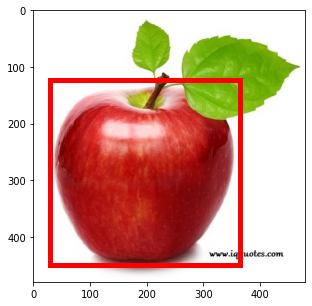

In [69]:

test_dataset = FruitsDataset(test_dir, 480, 480, transforms= get_transform(train=False))
img, target = test_dataset[10]
model.eval()
with torch.no_grad():
  prediction = model([img.to(hyper_params.device)])[0]
    
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction["boxes"] = nms_prediction["boxes"].cpu()
nms_prediction["labels"] = nms_prediction["labels"].cpu() 
# nms_prediction.to(device="cpu")
plot_img_bbox(torch_to_pil(img.cpu()), nms_prediction)
print(nms_prediction)

MODEL OUTPUT

{'boxes': tensor([[ 49.9449,  27.8417, 465.0362, 426.5949],
        [  0.0000, 479.5812,   5.3337, 479.9945]]), 'labels': tensor([1, 2]), 'scores': tensor([0.9875, 0.0757], device='cuda:0')}


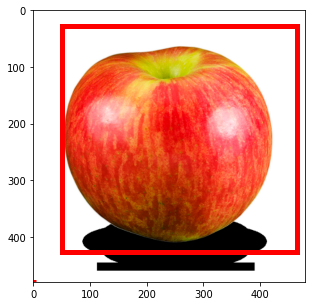

In [70]:
img, target = test_dataset[15]
model.eval()
with torch.no_grad():
  prediction = model([img.to(hyper_params.device)])[0]
    
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction["boxes"] = nms_prediction["boxes"].cpu()
nms_prediction["labels"] = nms_prediction["labels"].cpu() 
# nms_prediction.to(device="cpu")
plot_img_bbox(torch_to_pil(img.cpu()), nms_prediction)
print(nms_prediction)

MODEL OUTPUT

{'boxes': tensor([[ 97.5537,  74.1921, 358.1124, 395.8225],
        [479.9759, 313.2722, 480.0000, 321.6402],
        [479.9307, 255.7350, 480.0000, 263.8639],
        [479.9557, 215.7630, 480.0000, 224.6397],
        [479.8095, 200.5524, 479.9992, 209.5040],
        [479.8146, 289.1704, 479.9993, 298.6697],
        [479.8191, 186.7284, 479.9994, 195.7860],
        [479.7897, 228.8707, 479.9992, 237.9555]]), 'labels': tensor([3, 2, 2, 2, 3, 3, 3, 3]), 'scores': tensor([0.9217, 0.2184, 0.2184, 0.2184, 0.1016, 0.0996, 0.0973, 0.0964],
       device='cuda:0')}


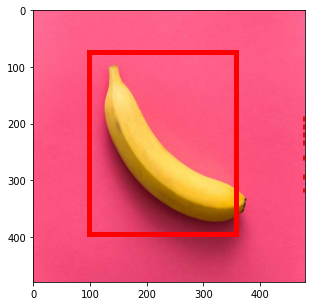

In [71]:
img, target = test_dataset[30]
model.eval()
with torch.no_grad():
  prediction = model([img.to(hyper_params.device)])[0]
    
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction["boxes"] = nms_prediction["boxes"].cpu()
nms_prediction["labels"] = nms_prediction["labels"].cpu() 
# nms_prediction.to(device="cpu")
plot_img_bbox(torch_to_pil(img.cpu()), nms_prediction)
print(nms_prediction)